## Dependencies

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtw import DTW
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


## Load dataset

In [2]:
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv',header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv',header=None)

X = train_data.iloc[:,:-1].values
y = train_data.iloc[:,-1].values.astype(int)

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

X_test = test_data.iloc[:,:-1].values
y_test = test_data.iloc[:,-1].values.astype(int)

### EDA

#### 🔢 Class Labels in ECG Heartbeat Categorization Dataset (Kaggle)

The dataset uses the AAMI standard to group heartbeats into five major classes:

| Label | Code | Description |
|-------|------|-------------|
| 0     | N    | **Normal and Bundle Branch Block beats** — Includes normal beat (N), left bundle branch block beat (L), right bundle branch block beat (R), atrial escape beat (A), and nodal (junctional) escape beat (J). |
| 1     | S    | **Supraventricular ectopic beats** — Includes atrial premature beat (A), abnormal atrial beat (a), and nodal premature beat (J). These originate above the ventricles but outside the sinus node. |
| 2     | V    | **Ventricular ectopic beats** — Includes premature ventricular contraction (V) and ventricular escape beat (E). These originate in the ventricles and are often considered more serious. |
| 3     | F    | **Fusion beats** — Includes fusion of normal and ventricular beats (F). These occur when both a ventricular and a normal beat activate the ventricles simultaneously. |
| 4     | Q    | **Unknown beats** — Includes paced beats (/), fusion of paced and normal beats (f), and other unclassified beats. These are generally excluded from analysis. |


C:\Users\harsh\AppData\Local\Temp\ipykernel_11428\4125413524.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


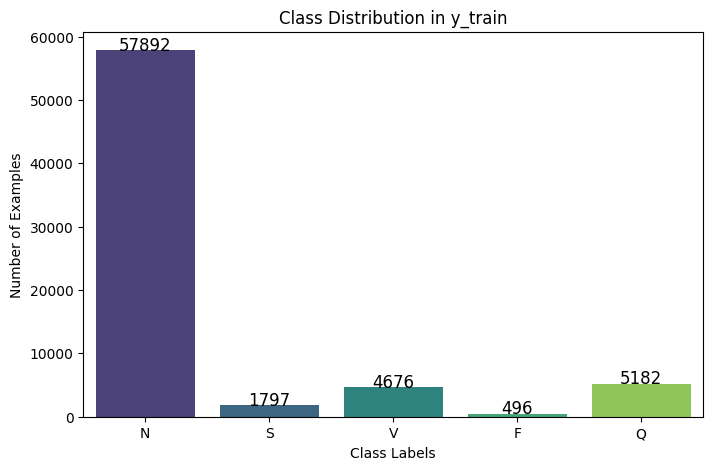

In [3]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

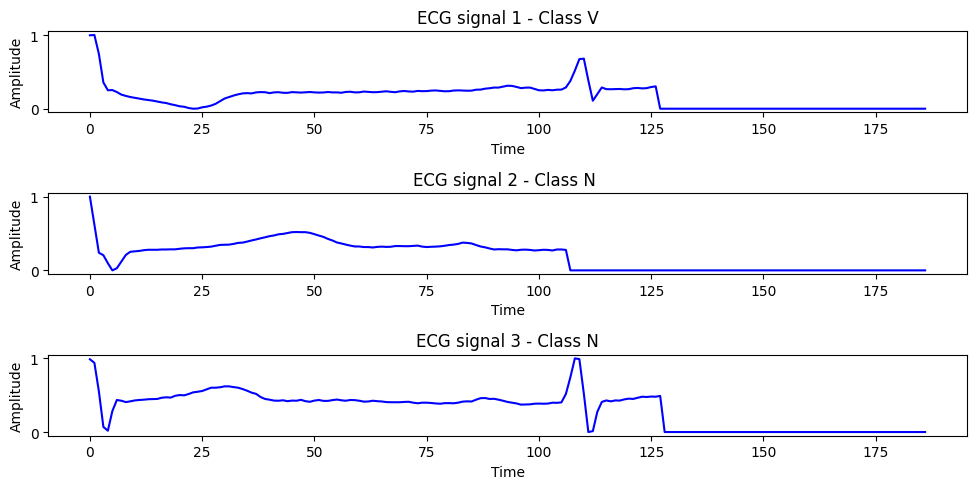

In [4]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(X_train[0],label='Sample 1',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 1 - Class {class_mapping[y_train[0]]}')


plt.subplot(3,1,2)
plt.plot(X_train[1],label='Sample 2',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 2 - Class {class_mapping[y_train[1]]} ')


plt.subplot(3,1,3)
plt.plot(X_train[2],label='Sample 3',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 3 - Class {class_mapping[y_train[1]]}')


plt.tight_layout()
plt.show()

0.017424515359217175


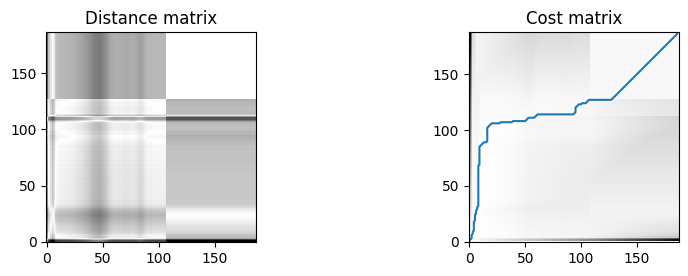

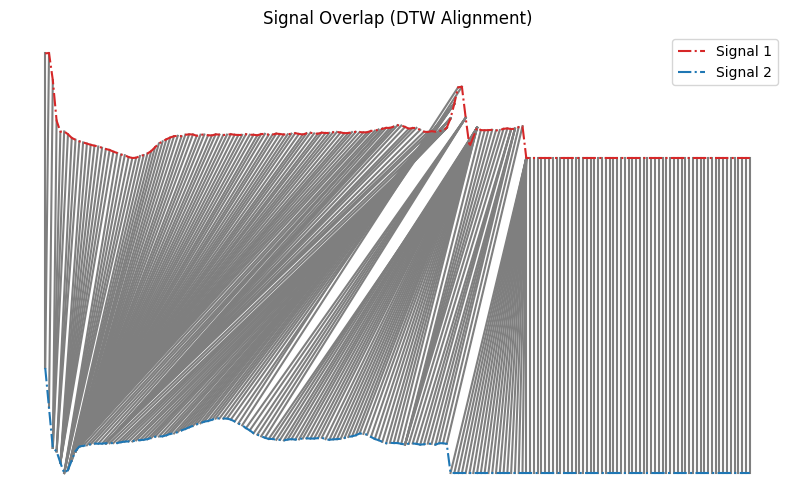

In [5]:
# Visualize signals 1 & 2 for using DTW

dtw_model = DTW(signal1=X_train[0],signal2=X_train[1])
distance = dtw_model.compute()
print(distance)
dtw_model.visualize()

0.033232756266136754


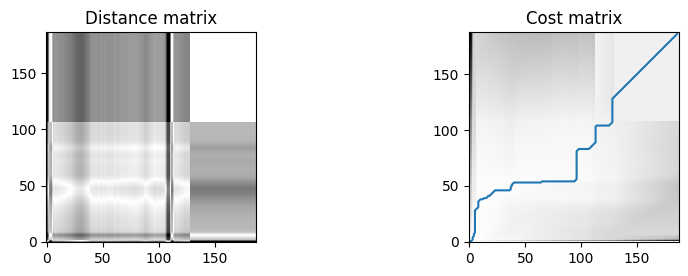

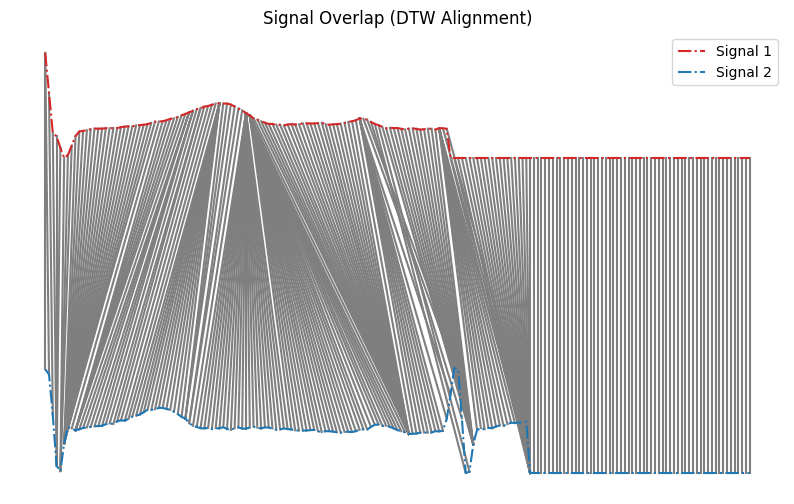

In [6]:
# Visualize signals 2 & 3 for using DTW

dtw_model = DTW(signal1=X_train[1],signal2=X_train[2])
distance = dtw_model.compute()
print(distance)
dtw_model.visualize()

## Train KNN classifier

In [ ]:
def dtw_wrapper(x, y):
    return DTW(x, y, normalized=True).compute()

# Had to stop the model at 547 minutes, took too long to run on full dataset

model = KNeighborsClassifier(n_neighbors=3,metric=dtw_wrapper,weights='distance',algorithm='brute')
model.fit(X_train,y_train)
y_val_pred = model.predict(X_val)

KeyboardInterrupt: 

In [ ]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

In [ ]:
import joblib

joblib.dump(model, 'dtw_knn_model.pkl')